# Feladatok a klaszteranalízis témaköréből

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. feladat

A Digitális méréstechnika laboratórium _Képfeldolgozás_ mérésében az egyik feladat célja a kamera leképező mátrixának meghatározása. 
Ehhez legalább 6 térbeli pont pozícióját kell ismernünk és hozzá kell rendelnünk a kameraképen található pixelpozíciókat. 
A rögzített képen (`/v/courses/adattudomany.public/clusteranalysis/cameracal.png`) a fehér csoportok felderítésére használd a _k-közép_ módszert!

* Készítsd el az algoritmus saját változatát. 
* Az algoritmus iterációs lépéseiben jegyezd fel a célfüggvény értékét, és ábrázold az időfejlődést!
* Melyik klaszter járuléka a legnagyobb?


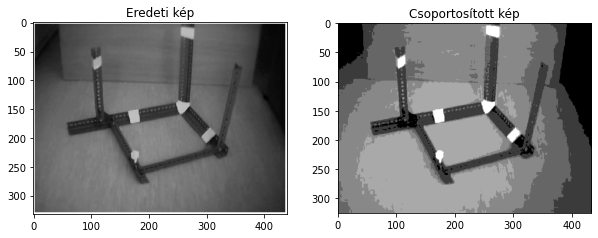

In [2]:
import cv2
from skimage import io, color
from sklearn.mixture import GaussianMixture

def k_means(image, k, max_iterations=100):
    image = image[3:-3, 3:-3] #úgy vettem észre, hogy alapból van egy fehér keret a képeken, ezeket levagdostam
    gray_image = color.rgb2gray(color.rgba2rgb(image)) #szürkeárnyalatossá konvertáltam őket, hogy a fehért jobban el tudjuk különíteni

    rows, cols = gray_image.shape #kimentjük, hogy vissza tudjuk állítani az eredeti méretű képeket
    
    # Kép adatainak laposítása
    data = gray_image.flatten()

    # K-közép csoportok inicializálása
    np.random.seed(4)
    centers = np.random.choice(data, size=k, replace=False) #elhelyezzük a klaszterek pontjait
    
    for _ in range(max_iterations):
        #kiszámítjuk a centerektől való távolságot, kvázi szinekre bontom
        distances = np.abs(data - centers[:, np.newaxis])
        
        #kiválasztjuk a legközelebbi centert
        labels = np.argmin(distances, axis=0)
        
        #kiszámolja az új center értéket a csoport átlagok alapján
        new_centers = np.array([np.mean(data[labels == i]) for i in range(k)])
        
       
        
        centers = new_centers
    
    #A csoportokhoz tartozó képek
    segmented_image = centers[labels].reshape(rows, cols)
    
    return segmented_image

image = io.imread('/v/courses/adattudomany.public/clusteranalysis/cameracal.png')

#létrehozzuk a szegmentált képet
segmented_image = k_means(image, k=6)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(color.rgb2gray(color.rgba2rgb(image)), cmap='gray')
plt.title('Eredeti kép')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title('Csoportosított kép')

plt.show()


In [3]:

def white_zone_filtering(segmented_image):
    brightest_pixels = np.where(segmented_image == np.max(segmented_image))
    segmented_image[:,:] = 0
    segmented_image[brightest_pixels] = 255  
    return segmented_image

In [4]:
white_detect = white_zone_filtering(segmented_image)

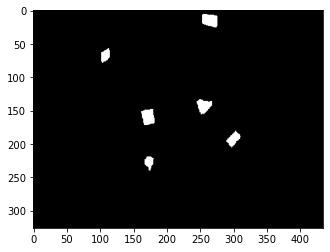

In [5]:
plt.imshow(white_detect,cmap = "gray")

Hogy még jobban szeparáljam a fehér zónákat, létrehoztam ezt az egyszerű kis függvényt, ami szimplán azt csinálja, hogy kiválasztja a szegmentált képen a legmagasabb (legvilágosabb) értékhez tartozó indexeket, ezek értékét 255-re állítja, azaz tökéletesen fehérre, és minden más egyéb értéket 0-ra azaz feketére állít.

## 2. feladat

Próbáld elvégezni az előző feladathoz kiadott minta képen a _fehér_ pixelek hierarchikus egyesítő klaszterezését. Szerkeszd meg a dendrogramot és az alapján lásd be, hogy hány tipikus csoport van a képen. 

Mit tapasztalsz, ha a képen véletlenszerűen kiválasztott képpontok _fehérré_ válnak?

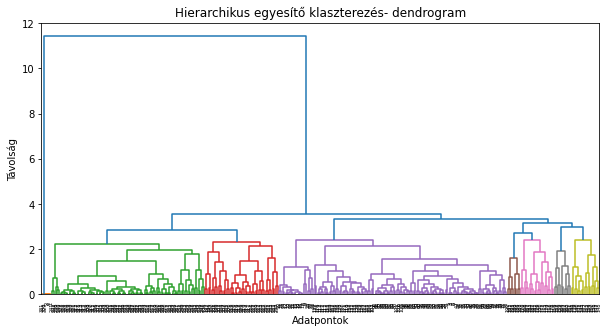

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

#kép betöltése
image = io.imread('/v/courses/adattudomany.public/clusteranalysis/cameracal.png')

#itt is szintén fekete-fehérré konvertáltam a képet
data = color.rgb2gray(color.rgba2rgb(image))



#hierarchikus klaszterezés
linked = linkage(data, 'complete') #"complete" methodot használtam,ami a klaszterek közti maximális távolságot veszi figyelembe 

#dendrogram létrehozása
plt.figure(figsize=(10, 5))
dendrogram(linked, labels=range(len(data)), color_threshold=2.5) #erre az értékre számos porbálkozást követően esett a választás
plt.title('Hierarchikus egyesítő klaszterezés- dendrogram')
plt.xlabel('Adatpontok')

plt.ylabel('Távolság')
plt.show()


Nehéz megmondani pontosan, hogy hány típikus csoport van, most így első ránézésre azt mondanám, hogy ha a legnagyobb távolságot nézzük a csoportok között, akkor kettő.

## 3. feladat

Van két adatsorunk:

* első adatsor `/v/courses/adattudomany.public/clusteranalysis/gm1.dat` és
* második adatsor `/v/courses/adattudomany.public/clusteranalysis/gm2.dat`. 

Az a sejtésünk, hogy mindkettő modellezhető normális eloszlású véletlen folyamatok keverékeként. Használj Gauss-mixture-modellt a paraméterek meghatározására!

In [7]:
def datreader(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data = [line.split() for line in lines[5:]]
    data_float = [[float(element) for element in row] for row in data]
    data_float = data_float[0]
    return data_float

In [8]:
data1 = datreader("/v/courses/adattudomany.public/clusteranalysis/gm1.dat")

In [9]:
data1 = np.array(data1)

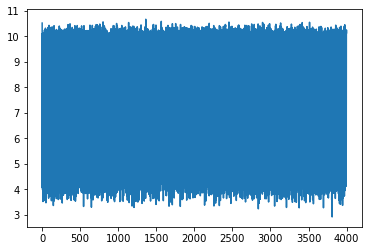

In [10]:
plt.plot(data1)

In [11]:
data2 = np.loadtxt('/v/courses/adattudomany.public/clusteranalysis/gm2.dat')

(array([ 295.,   13.,    0.,  279.,  340.,  509., 1372.,  541.,  375.,
         276.]),
 array([-18.98212569, -15.26060215, -11.53907861,  -7.81755507,
         -4.09603153,  -0.37450799,   3.34701555,   7.06853908,
         10.79006262,  14.51158616,  18.2331097 ]),
 <BarContainer object of 10 artists>)

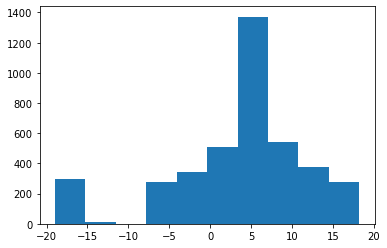

In [12]:
plt.hist(data2[:,0]+ data2[:,1]) 

In [13]:
data3 = data2[:,0]+ data2[:,1] 

Komponens 1:
Mean: 3.997331994906467
Covariance: 0.079754512428111
Weight: 0.25

Komponens 2:
Mean: 9.999122758835524
Covariance: 0.04006820946109011
Weight: 0.75



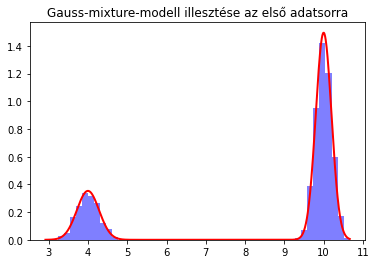

In [14]:
from sklearn.mixture import GaussianMixture

data1 = np.loadtxt('/v/courses/adattudomany.public/clusteranalysis/gm1.dat')

# Gauss-mixture-modell 
num_components = 2  
model = GaussianMixture(n_components=num_components)


model.fit(data1.reshape(-1, 1))  #Az adatokat át kellet formálni, hogy az sklearn tudjon vele dolgozni

#paraméterek
means = model.means_
covariances = model.covariances_
weights = model.weights_

#eredmények
for i in range(num_components):
    print(f'Komponens {i + 1}:')
    print(f'Mean: {means[i][0]}')
    print(f'Covariance: {covariances[i][0][0]}')
    print(f'Weight: {weights[i]}')
    print()

#hisztogram, hogy lássuk hogy valóban gauss mixture modell az eloszlásuk
plt.hist(data1, bins=50, density=True, alpha=0.5, color='blue')

x = np.linspace(min(data1), max(data1), 1000)
y = np.zeros_like(x)

for i in range(num_components): #rá illesztem az gaussokat
    y += weights[i] * np.exp(-(x - means[i]) ** 2 / (2 * covariances[i][0][0])) / np.sqrt(2 * np.pi * covariances[i][0][0])

plt.plot(x, y, color='red', linewidth=2)
plt.title('Gauss-mixture-modell illesztése az első adatsorra')
plt.show()


Komponens 1:
Mean: 5.278665390898074
Covariance: 5.997005565870624
Weight: 0.5922350037868087

Komponens 2:
Mean: -16.78546952263728
Covariance: 0.732309764558917
Weight: 0.07699999999999996

Komponens 3:
Mean: -3.9286142793329617
Covariance: 1.5985259202347715
Weight: 0.15168812614789295

Komponens 4:
Mean: 13.661914138186237
Covariance: 4.199753247754972
Weight: 0.17907687006529827



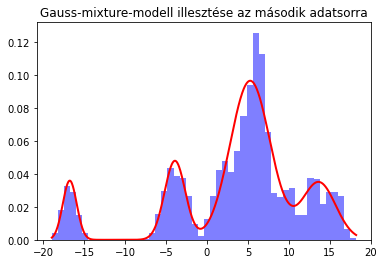

In [15]:
from sklearn.mixture import GaussianMixture


# Gauss-mixture-modell 
num_components = 4 
model = GaussianMixture(n_components=num_components)


model.fit(data3.reshape(-1, 1))  #Az adatokat át kellet formálni, hogy az sklearn tudjon vele dolgozni

#paraméterek
means = model.means_
covariances = model.covariances_
weights = model.weights_

#eredmények
for i in range(num_components):
    print(f'Komponens {i + 1}:')
    print(f'Mean: {means[i][0]}')
    print(f'Covariance: {covariances[i][0][0]}')
    print(f'Weight: {weights[i]}')
    print()

#hisztogram, hogy lássuk hogy valóban gauss mixture modell az eloszlásuk
plt.hist(data3, bins=50, density=True, alpha=0.5, color='blue')

x = np.linspace(min(data3), max(data3), 1000)
y = np.zeros_like(x)

for i in range(num_components): #rá illesztem az gaussokat
    y += weights[i] * np.exp(-(x - means[i]) ** 2 / (2 * covariances[i][0][0])) / np.sqrt(2 * np.pi * covariances[i][0][0])

plt.plot(x, y, color='red', linewidth=2)
plt.title('Gauss-mixture-modell illesztése az második adatsorra')
plt.show()


A második fájl 2 db  4000 elemből álló adatsort tartalmazott, megvizsgáltam külön-külön a hisztogrammjukat de úgy nem igazán mutattak gauss eloszlást, utánna összeadtam a kettőt és akkor már valami gauss jellegű eloszlást lett azt eredmény. A komponensek számát kettőről négyre emeltem, így egy egész jó illesztést sikerült végül kapnom. 

## 4. feladat
Vizsgáld meg a [wikipedián közzétett adatokat](https://en.wikipedia.org/wiki/Iris_flower_data_set). A nőszirom 4 fenotipikus jellemzője alapján próbáld meg jellemezni a vizsgált 3 fajt Gauss-keverék-modell segítségével.

In [16]:
from sklearn.datasets import load_iris

iris = load_iris()
#iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [17]:
data = iris.data

#kiválasztattom az adatokat tartalamzó részt
gmm = GaussianMixture(n_components=3, random_state= 10)
gmm.fit(data)

#és elvégeztem rajtuk a klaszterek predikcióját 3 komponensre (3 faj)
labels = gmm.predict(data)

# eredmények
print("GMM Parameters:")
print("Means:\n", gmm.means_)
print("\nCovariances:\n", gmm.covariances_)
print("\nWeights:\n", gmm.weights_)

#Előre jelzett csoportok 
print("\nPredicted Labels:\n", labels)

GMM Parameters:
Means:
 [[5.006      3.428      1.462      0.246     ]
 [6.54639415 2.94946365 5.48364578 1.98726565]
 [5.9170732  2.77804839 4.20540364 1.29848217]]

Covariances:
 [[[0.121765   0.097232   0.016028   0.010124  ]
  [0.097232   0.140817   0.011464   0.009112  ]
  [0.016028   0.011464   0.029557   0.005948  ]
  [0.010124   0.009112   0.005948   0.010885  ]]

 [[0.38744093 0.09223276 0.30244302 0.06087397]
  [0.09223276 0.11040914 0.08385112 0.05574334]
  [0.30244302 0.08385112 0.32589574 0.07276776]
  [0.06087397 0.05574334 0.07276776 0.08484505]]

 [[0.2755171  0.09662295 0.18547072 0.05478901]
  [0.09662295 0.09255152 0.09103431 0.04299899]
  [0.18547072 0.09103431 0.20235849 0.06171383]
  [0.05478901 0.04299899 0.06171383 0.03233775]]]

Weights:
 [0.33333333 0.36539575 0.30127092]

Predicted Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 1 2
 2 2 2 1 2 2 2 2 2 1 

In [18]:
len(np.where(labels == 0)[0]) #első 50 elem stimmel


50

In [19]:
len(np.where(labels[50:99]==2)[0]) # második részben 6 hiba

44

In [20]:
len(np.where(labels[100:149]==1)[0]) # végén 1 hiba

49

In [21]:
print(7/150*100,"%-os hiba") 

4.666666666666667 %-os hiba


Szerintem a tanúlság amit ebből levonhatunk az az, hogy viszonylag kis hibával jól megjósolta a csoportokat, mert szertinem nem a konkrét számozáson volt, a lényeg, hanem hogy ha már rosszul számoz, akkor az összeset ugyan úgy rosszul számozza, és ezt csupán 7 tévedéssel a 150 mintából, azaz 4.66 % hibával teljesítette.

## 5. feladat
Keress az Interneten betűket tartalmazó képeket, például rendszámtáblákról fotót. A _dbscan_ klaszterezési módszer segítségével keresd meg a betűket.

In [22]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN

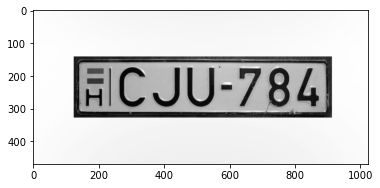

In [23]:
kep = cv2.imread("rendszám.png",0)
plt.imshow(kep,cmap = "gray")

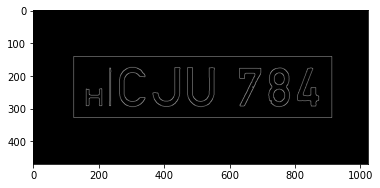

In [24]:
edges = cv2.Canny(kep, 800, 300)
plt.imshow(edges,cmap = "gray")

In [27]:
dbscan = DBSCAN(eps=10, min_samples=5)
labels = dbscan.fit_predict(edges)

In [28]:
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [31]:
dbscan = DBSCAN(eps=100, min_samples=5)
labels = dbscan.fit_predict(edges)

unique_labels = set(labels)
clusters = [edges[labels == label] for label in unique_labels if label != -1] #a -1 zajnak van definiálva

#eredmények
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1}: {len(cluster)} points")

Cluster 1: 282 points
Cluster 2: 64 points


Bárhogy állítgattam az epsilon értékét, csak két clustert tudott megkülönböztetni egymástól, ami nem volt elég a betűk pozíciójának meghatározásához.

## 6. feladat

Keress az Interneten egy színes mintaképet. A színes pixeleket klaszterezd _k-közép_ módszer segítségével és készítsd el az új képet, amin a reprezentáns színekkel *(centroid)* helyetteseíted az eredeti pixeleket. Szímszerűsítsd a tömörítés mértékét, próbáld számszerűsíteni az eredeti és a tömörített kép különbségét. Ez hogyan függ $k$ paramétertől? Több különböző témájú (pl. képregény kocka, portré, impresszionista festmény, természetfotó, clipart) képet használva mit tapasztalsz.

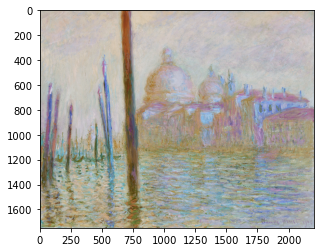

In [32]:
image = cv2.imread("Monet_Le_Grand_Canal.jpg")
imshow(image)

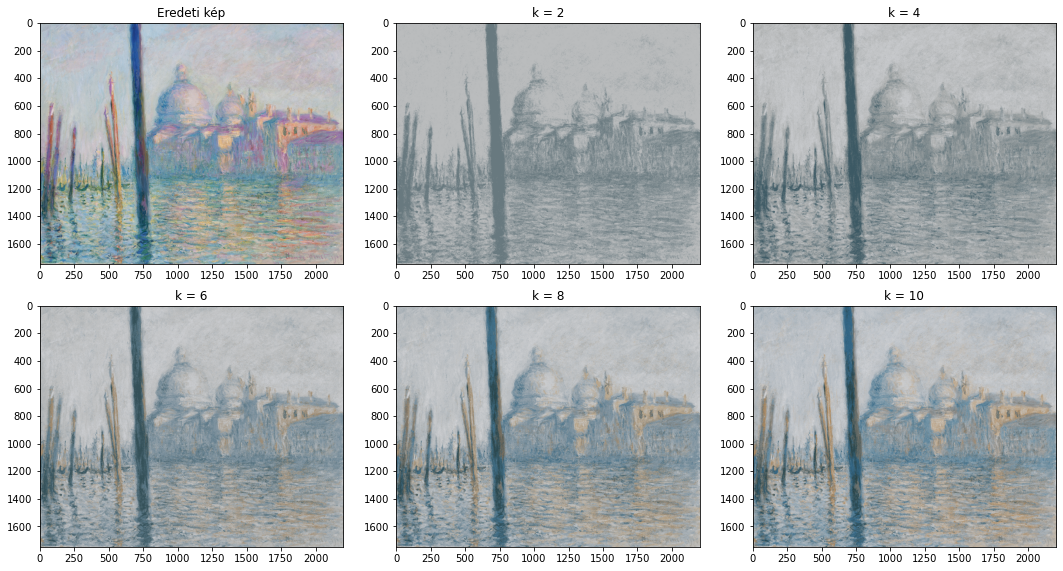

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 15 µs
CPU times: user 8min 42s, sys: 2min 52s, total: 11min 34s
Wall time: 4min 22s


In [33]:
%%time
from sklearn.cluster import KMeans

def k_means_clustering(image, k):
    pixels = image.reshape((-1, 3)) #át kellet formálni, hogy a Kmeans felsimerje
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    segmented_image = centers[labels].reshape(image.shape) #akárcsak az első feladtban létrehoztam a szegnmentált képeket
    return segmented_image

image = cv2.imread("Monet_Le_Grand_Canal.jpg")

#clusterezés különöző k értékek melett
k_values = [2, 4, 6, 8, 10]

plt.figure(figsize=(15, 8))

#Az eredeti kép referenciának
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Eredeti kép')

#különböző k értékekkel való clusterezés
for i, k in enumerate(k_values):
    segmented_image = k_means_clustering(image, k)
    plt.subplot(2, 3, i + 2)
    plt.imshow(cv2.cvtColor(segmented_image.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f'k = {k}')

plt.tight_layout()
plt.show()


Nem ajánlom az újra futtatását, nekem a legutolsó alkalommal 11 és fél percet vett igénybe. A tapasztalatom az, hogy ahogy növelevem a k értékét, úgy egyre inkább nyeri vissza az eredeti színeit a kép. 